# Reference

Data: https://www.phila.gov/property/data/

Reference: https://medium.com/@GaussEuler/philadelphia-housing-data-part-i-data-analysis-fe45415554a9

# Preparing Dataset

In [47]:
#!Powershell.exe -Command "Invoke-WebRequest -Uri 'https://phl.carto.com/api/v2/sql?q=SELECT+*,+ST_Y(the_geom)+AS+lat,+ST_X(the_geom)+AS+lng+FROM+opa_properties_public&filename=opa_properties_public&format=csv&skipfields=cartodb_id' -OutFile 'data.csv'"


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import category_encoders as ce

In [49]:
df = pd.read_csv('data.csv')

C:\Users\Paul\AppData\Local\Temp\ipykernel_10596\1507164070.py:1: DtypeWarning: Columns (5,26,49,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv')


In [50]:
df.shape

(582933, 82)

# Preprocessing

In [51]:
df.head()

,the_geom,the_geom_webmercator,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,year_built,year_built_estimate,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,lat,lng
0,0101000020E610000029C6C53D2BCC52C0DD31054E9CF7...,0101000020110F0000D6E1D100F4ED5FC11AC63D999986...,2022-05-24,NaN,SWC OF DICKINSON ST,NaN,SR,VACANT LAND RESIDE < ACRE,6,VACANT LAND,...,NaN,NaN,19146.0,RSA5,1001202566,NaN,NaN,437224013,39.934458,-75.190139
1,0101000020E6100000B08BC01062CB52C0B80FFF2AA3FF...,0101000020110F0000F67827499EEC5FC1F75C95A67E8F...,2022-05-24,NaN,NEC DOVER ST,NaN,SC,VACANT LAND COMMER < ACRE,6,VACANT LAND,...,NaN,NaN,19132.0,CMX1,1001321879,NaN,NaN,437224014,39.997167,-75.177860
2,0101000020E61000001A1448DC39CB52C0DD45FFD4CBF4...,0101000020110F000094715BFE59EC5FC164CB68B77B83...,2022-05-24,NaN,NWC 16TH ST,NaN,T38,ROW B/OFF-STR 2 STY STONE,3,MIXED USE,...,1950.0,NaN,19145.0,CMX1,1001408261,820,ROW MIXED-COM/RES-BLT AS RES,437224015,39.912470,-75.175407
3,0101000020E610000084BBFD1FCCCB52C0785516F4F9FE...,0101000020110F0000150E447052ED5FC12914760FC38E...,2022-05-24,NaN,"343'7 1/8"" W 31ST ST",NaN,SR,VACANT LAND RESIDE < ACRE,6,VACANT LAND,...,NaN,NaN,19132.0,RSA5,1001168670,NaN,NaN,437224016,39.992003,-75.184334
4,0101000020E6100000D94623BCE3CA52C06001DBCC5EFB...,0101000020110F00009EC95DB3C7EB5FC1430D34E8C38A...,2022-05-24,NaN,197' W OF 19TH ST,NaN,ZL0,MISC FUNERAL HOME MASONRY,4,COMMERCIAL,...,1920.0,NaN,19130.0,RM1,1001494378,246,FUNERAL HOME,437224017,39.963831,-75.170150


In [52]:
df.columns

Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', 'owner_2', 'parcel_number', 'parcel_shape',
       'quality_grade', 'recording_d

## Initial Drops after combing through the data.

Getting all columns with missing values > 20%.

In [53]:
missing_percent = df.isnull().mean() * 100
columns_missing = missing_percent[missing_percent > 20].index.tolist()
columns_missing


['basements',
 'central_air',
 'cross_reference',
 'date_exterior_condition',
 'fuel',
 'garage_type',
 'house_extension',
 'mailing_address_1',
 'mailing_address_2',
 'mailing_care_of',
 'market_value_date',
 'number_of_rooms',
 'other_building',
 'owner_2',
 'separate_utilities',
 'sewer',
 'site_type',
 'street_direction',
 'suffix',
 'type_heater',
 'unfinished',
 'unit',
 'utility',
 'year_built_estimate']

Text(0.5, 0, 'Number of Missing values')

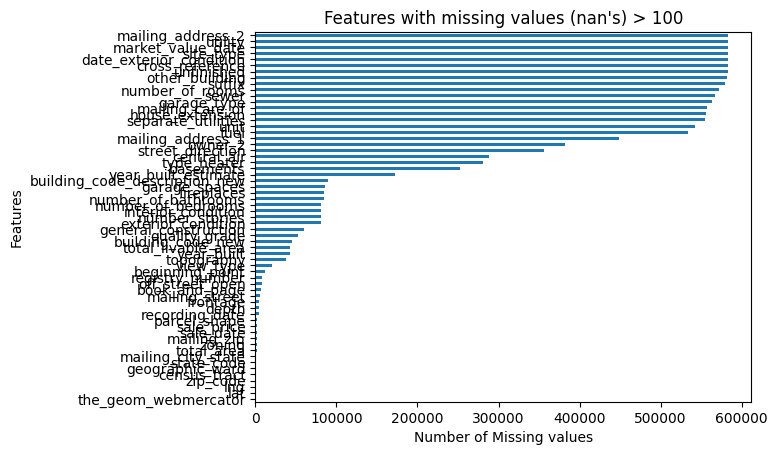

In [54]:
missing = df.isnull().sum()
missing = missing[missing >= 100]
missing.sort_values(inplace=True)
missing.plot.barh()
plt.title("Features with missing values (nan's) > 100")
plt.ylabel("Features")
plt.xlabel("Number of Missing values")

Both of the above code snippets give us a good idea about how the data is being maintained. To make this dataset easier to work with, we will drop a majority of these columns. Since we have 582933 rows across 82 columns, there is no reason to worry about a few columns.

In [55]:
DROP_DATA = """
basements
central_air
cross_reference
date_exterior_condition
fuel
garage_type
house_extension
mailing_address_1
mailing_address_2
mailing_care_of
market_value_date
number_of_rooms
other_building
owner_2
separate_utilities
sewer
site_type
street_direction
suffix
type_heater
unfinished
unit
utility
year_built_estimate
"""

def clean_data(df):
    # Drop columns with >20% missing values
    df = df.drop(columns=DROP_DATA.split())
    return df

df_dropped_missing = clean_data(df.copy())
df_dropped_missing.head()

,the_geom,the_geom_webmercator,assessment_date,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,...,view_type,year_built,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,lat,lng
0,0101000020E610000029C6C53D2BCC52C0DD31054E9CF7...,0101000020110F0000D6E1D100F4ED5FC11AC63D999986...,2022-05-24,SWC OF DICKINSON ST,NaN,SR,VACANT LAND RESIDE < ACRE,6,VACANT LAND,33.0,...,I,NaN,19146.0,RSA5,1001202566,NaN,NaN,437224013,39.934458,-75.190139
1,0101000020E6100000B08BC01062CB52C0B80FFF2AA3FF...,0101000020110F0000F67827499EEC5FC1F75C95A67E8F...,2022-05-24,NEC DOVER ST,NaN,SC,VACANT LAND COMMER < ACRE,6,VACANT LAND,172.0,...,I,NaN,19132.0,CMX1,1001321879,NaN,NaN,437224014,39.997167,-75.177860
2,0101000020E61000001A1448DC39CB52C0DD45FFD4CBF4...,0101000020110F000094715BFE59EC5FC164CB68B77B83...,2022-05-24,NWC 16TH ST,NaN,T38,ROW B/OFF-STR 2 STY STONE,3,MIXED USE,373.0,...,I,1950.0,19145.0,CMX1,1001408261,820,ROW MIXED-COM/RES-BLT AS RES,437224015,39.912470,-75.175407
3,0101000020E610000084BBFD1FCCCB52C0785516F4F9FE...,0101000020110F0000150E447052ED5FC12914760FC38E...,2022-05-24,"343'7 1/8"" W 31ST ST",NaN,SR,VACANT LAND RESIDE < ACRE,6,VACANT LAND,169.0,...,I,NaN,19132.0,RSA5,1001168670,NaN,NaN,437224016,39.992003,-75.184334
4,0101000020E6100000D94623BCE3CA52C06001DBCC5EFB...,0101000020110F00009EC95DB3C7EB5FC1430D34E8C38A...,2022-05-24,197' W OF 19TH ST,NaN,ZL0,MISC FUNERAL HOME MASONRY,4,COMMERCIAL,134.0,...,A,1920.0,19130.0,RM1,1001494378,246,FUNERAL HOME,437224017,39.963831,-75.170150


In [56]:
# Get all unique values of (category_code, category_code_description)
df_dropped_missing[['category_code', 'category_code_description']].drop_duplicates().sort_values(by='category_code')

,category_code,category_code_description
43,1,SINGLE FAMILY
34,2,MULTI FAMILY
2,3,MIXED USE
4,4,COMMERCIAL
263,5,INDUSTRIAL
0,6,VACANT LAND
1339,7,GARAGE - COMMERCIAL
3035,8,GARAGE - RESIDENTIAL
6776,9,HOTEL
1316,10,OFFICES


Remove non-residential homes

We can see that there are several types of buildings in this dataset. Since we are really only interested in the housing market we can really afford to drop all but the single and multi family.

In [57]:
def clean_data(df_dropped_missing):
    # Filter rows based on column: 'category_code' This keeps single family and multi-family
    df_dropped_missing = df_dropped_missing[df_dropped_missing['category_code'] <= 2]
    return df_dropped_missing
df_homes = clean_data(df_dropped_missing.copy())
df_homes.head()

,the_geom,the_geom_webmercator,assessment_date,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,census_tract,...,view_type,year_built,zip_code,zoning,pin,building_code_new,building_code_description_new,objectid,lat,lng
34,0101000020E610000066AC299B48CA52C053CA1DF46CFD...,0101000020110F00004ACDE132C0EA5FC17F6F06010B8D...,2022-05-24,"263' 8"" N COLUMBIA AVE",NaN,U50,ROW CONV/APT 3 STY MASON,2,MULTI FAMILY,147.0,...,I,1890.0,19121.0,RM1,1001622123,22,ROW TYPICAL,437224047,39.979887,-75.160682
40,0101000020E6100000F4DA6EE298CB52C0A7CFE56E61FC...,0101000020110F00005FFCC566FBEC5FC1ECE78683E28B...,2022-05-24,NW C PARRISH ST,NaN,U30,ROW CONV/APT 2 STY MASON,2,MULTI FAMILY,136.0,...,I,1935.0,19130.0,RSA5,1001644032,24,ROW PORCH FRONT,437224053,39.971723,-75.181206
43,0101000020E61000004CEB419C25CB52C0B0C42A3BE2FE...,0101000020110F0000F24AC59837EC5FC1D8D057C3A88E...,2022-05-24,"173'1 3/4"" W OF 25TH",NaN,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,169.0,...,I,1915.0,19132.0,RSA5,1001071884,22,ROW TYPICAL,437224056,39.991279,-75.174171
74,0101000020E610000003ED27D222C852C0361FFBA612FD...,0101000020110F0000A93153551AE75FC1BE2684EBA68C...,2022-05-24,"69'11 1/2"" N OF",NaN,V10,PRIV GAR 1 STY MASONRY,1,SINGLE FAMILY,160.0,...,I,1899.0,19125.0,RSA5,1001129558,NaN,NaN,437224008,39.977132,-75.127125
82,0101000020E61000009E7E966CAEC952C0A168D1CC05FF...,0101000020110F00002D80234EBAE95FC1DBB56931D08E...,2022-05-24,NWC HAROLD ST,NaN,U50,ROW CONV/APT 3 STY MASON,2,MULTI FAMILY,165.0,...,I,1920.0,19133.0,CMX2,1001614748,22,ROW TYPICAL,437224159,39.992365,-75.151271


Drop Unrelated Data

There are still a few columns we will have no way of using in the models we are trying to make so we can drop them as well.

In [58]:

def clean_data(df_homes):
    # Drop columns: 'the_geom', 'the_geom_webmercator' and 22 other columns
    df_homes = df_homes.drop(columns=['the_geom', 'the_geom_webmercator', 'assessment_date', 'beginning_point', 'book_and_page', 'building_code', 'building_code_description', 'category_code_description', 'general_construction', 'house_number', 'location', 'mailing_city_state', 'mailing_street', 'mailing_zip', 'owner_1', 'parcel_number', 'quality_grade', 'recording_date', 'registry_number', 'sale_date', 'state_code', 'street_designation', 'street_name', 'pin', 'building_code_description_new', 'building_code_new', 'objectid'])
    return df_homes

df_homes_clean = clean_data(df_homes.copy())
df_homes_clean.head()

,category_code,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,...,taxable_land,topography,total_area,total_livable_area,view_type,year_built,zip_code,zoning,lat,lng
34,2,147.0,100.0,329760.0,82440.0,4.0,0.0,16.0,0.0,47.0,...,0.0,F,1600.0,2540.0,I,1890.0,19121.0,RM1,39.979887,-75.160682
40,2,136.0,78.0,311700.0,0.0,3.0,0.0,16.0,2.0,15.0,...,116100.0,F,1244.0,1280.0,I,1935.0,19130.0,RSA5,39.971723,-75.181206
43,1,169.0,44.0,32000.0,8000.0,4.0,0.0,14.0,0.0,28.0,...,0.0,F,609.0,840.0,I,1915.0,19132.0,RSA5,39.991279,-75.174171
74,1,160.0,64.0,0.0,0.0,4.0,0.0,14.0,0.0,31.0,...,2600.0,F,776.0,258.0,I,1899.0,19125.0,RSA5,39.977132,-75.127125
82,2,165.0,71.0,145280.0,36320.0,4.0,0.0,15.0,0.0,37.0,...,0.0,F,1065.0,2550.0,I,1920.0,19133.0,CMX2,39.992365,-75.151271


In [59]:
df_homes_clean.dtypes

category_code            int64
census_tract           float64
depth                  float64
exempt_building        float64
exempt_land            float64
exterior_condition     float64
fireplaces             float64
frontage               float64
garage_spaces          float64
geographic_ward        float64
homestead_exemption      int64
interior_condition     float64
market_value           float64
number_of_bathrooms    float64
number_of_bedrooms     float64
number_stories         float64
off_street_open        float64
parcel_shape            object
sale_price             float64
street_code            float64
taxable_building       float64
taxable_land           float64
topography              object
total_area             float64
total_livable_area     float64
view_type               object
year_built             float64
zip_code               float64
zoning                  object
lat                    float64
lng                    float64
dtype: object

Text(0.5, 0, 'Number of Missing values')

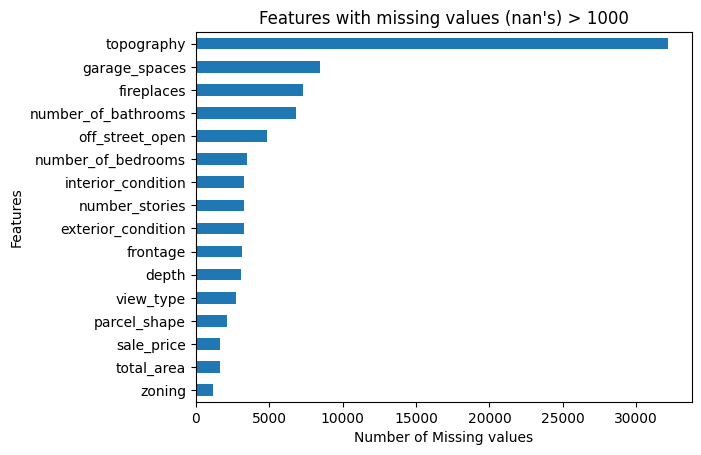

In [60]:
missing = df_homes_clean.isnull().sum()
missing = missing[missing >= 1000]
missing.sort_values(inplace=True)
missing.plot.barh()
plt.title("Features with missing values (nan's) > 1000")
plt.ylabel("Features")
plt.xlabel("Number of Missing values")

Dropping Missing Values

Since all of the missing values in each row account for less than 6% (all but 3 columns are less than 1%), we can drop the missing values.

In [61]:
def clean_data(df_homes_clean):
    # Drop rows with missing data across all columns
    df_homes_clean = df_homes_clean.dropna()
    # Drop duplicate rows across all columns
    df_homes_clean = df_homes_clean.drop_duplicates()
    return df_homes_clean

df_homes_clean_2 = clean_data(df_homes_clean.copy())
df_homes_clean_2.head()

,category_code,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,...,taxable_land,topography,total_area,total_livable_area,view_type,year_built,zip_code,zoning,lat,lng
34,2,147.0,100.0,329760.0,82440.0,4.0,0.0,16.0,0.0,47.0,...,0.0,F,1600.0,2540.0,I,1890.0,19121.0,RM1,39.979887,-75.160682
40,2,136.0,78.0,311700.0,0.0,3.0,0.0,16.0,2.0,15.0,...,116100.0,F,1244.0,1280.0,I,1935.0,19130.0,RSA5,39.971723,-75.181206
43,1,169.0,44.0,32000.0,8000.0,4.0,0.0,14.0,0.0,28.0,...,0.0,F,609.0,840.0,I,1915.0,19132.0,RSA5,39.991279,-75.174171
74,1,160.0,64.0,0.0,0.0,4.0,0.0,14.0,0.0,31.0,...,2600.0,F,776.0,258.0,I,1899.0,19125.0,RSA5,39.977132,-75.127125
82,2,165.0,71.0,145280.0,36320.0,4.0,0.0,15.0,0.0,37.0,...,0.0,F,1065.0,2550.0,I,1920.0,19133.0,CMX2,39.992365,-75.151271


Get ABS of Longitude

In [62]:
df_homes_clean_2.loc[:, "lng"] = df_homes_clean_2['lng'].abs()

Cleaning Datatypes

In [63]:
df_homes_clean_2.dtypes.value_counts()

float64    25
object      4
int64       2
Name: count, dtype: int64

In [64]:
# These need to be fixed, and the others need to be looked at as well
ONE_HOT = [
	'category_code',
	'parcel_shape',
	'topography',
	'view_type',

]
BINARY_ENCODING = [
	'zoning'
]

MAKE_BINARY = [
	'homestead_exemption',
	'exempt_building',
	'exempt_land'
]

Transform to Boolean

In [65]:
def clean_data(df_homes_clean_2):
    # Change column type to bool for column: 'exempt_building'
    df_homes_clean_2 = df_homes_clean_2.astype({'exempt_building': 'bool'})
    # Change column type to bool for column: 'exempt_land'
    df_homes_clean_2 = df_homes_clean_2.astype({'exempt_land': 'bool'})
    # Change column type to bool for column: 'homestead_exemption'
    df_homes_clean_2 = df_homes_clean_2.astype({'homestead_exemption': 'bool'})
    return df_homes_clean_2

df_encode = clean_data(df_homes_clean_2.copy())
df_encode.head()

,category_code,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,...,taxable_land,topography,total_area,total_livable_area,view_type,year_built,zip_code,zoning,lat,lng
34,2,147.0,100.0,True,True,4.0,0.0,16.0,0.0,47.0,...,0.0,F,1600.0,2540.0,I,1890.0,19121.0,RM1,39.979887,75.160682
40,2,136.0,78.0,True,False,3.0,0.0,16.0,2.0,15.0,...,116100.0,F,1244.0,1280.0,I,1935.0,19130.0,RSA5,39.971723,75.181206
43,1,169.0,44.0,True,True,4.0,0.0,14.0,0.0,28.0,...,0.0,F,609.0,840.0,I,1915.0,19132.0,RSA5,39.991279,75.174171
74,1,160.0,64.0,False,False,4.0,0.0,14.0,0.0,31.0,...,2600.0,F,776.0,258.0,I,1899.0,19125.0,RSA5,39.977132,75.127125
82,2,165.0,71.0,True,True,4.0,0.0,15.0,0.0,37.0,...,0.0,F,1065.0,2550.0,I,1920.0,19133.0,CMX2,39.992365,75.151271


One Hot Encoding

In [66]:
# One hot encode the columns
df_encode_2 = pd.get_dummies(df_encode, columns=ONE_HOT)
df_encode_2.head()

,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,homestead_exemption,...,topography_E,topography_F,view_type_0,view_type_A,view_type_B,view_type_C,view_type_D,view_type_E,view_type_H,view_type_I
34,147.0,100.0,True,True,4.0,0.0,16.0,0.0,47.0,False,...,False,True,False,False,False,False,False,False,False,True
40,136.0,78.0,True,False,3.0,0.0,16.0,2.0,15.0,False,...,False,True,False,False,False,False,False,False,False,True
43,169.0,44.0,True,True,4.0,0.0,14.0,0.0,28.0,False,...,False,True,False,False,False,False,False,False,False,True
74,160.0,64.0,False,False,4.0,0.0,14.0,0.0,31.0,False,...,False,True,False,False,False,False,False,False,False,True
82,165.0,71.0,True,True,4.0,0.0,15.0,0.0,37.0,False,...,False,True,False,False,False,False,False,False,False,True


Binary Encode Zoning so less dimensions

In [67]:
# Initialize the Binary Encoder
encoder = ce.BinaryEncoder(cols=['zoning'])

# Fit and transform to binary encode the column
df_encoded = encoder.fit_transform(df_encode_2['zoning'])

# Concatenate with original dataframe (if needed)
df_binencode = pd.concat([df_encode_2.drop('zoning', axis=1), df_encoded], axis=1)

df_binencode.head()

,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,homestead_exemption,...,view_type_D,view_type_E,view_type_H,view_type_I,zoning_0,zoning_1,zoning_2,zoning_3,zoning_4,zoning_5
34,147.0,100.0,True,True,4.0,0.0,16.0,0.0,47.0,False,...,False,False,False,True,0,0,0,0,0,1
40,136.0,78.0,True,False,3.0,0.0,16.0,2.0,15.0,False,...,False,False,False,True,0,0,0,0,1,0
43,169.0,44.0,True,True,4.0,0.0,14.0,0.0,28.0,False,...,False,False,False,True,0,0,0,0,1,0
74,160.0,64.0,False,False,4.0,0.0,14.0,0.0,31.0,False,...,False,False,False,True,0,0,0,0,1,0
82,165.0,71.0,True,True,4.0,0.0,15.0,0.0,37.0,False,...,False,False,False,True,0,0,0,0,1,1


Removing Outliers using IQR

In [68]:
def remove_outliers(df):
    for column in df.select_dtypes(include=np.number).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the function to the DataFrame
df_outliers = remove_outliers(df_binencode)

df_outliers.head()


,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,homestead_exemption,...,view_type_D,view_type_E,view_type_H,view_type_I,zoning_0,zoning_1,zoning_2,zoning_3,zoning_4,zoning_5
43,169.0,44.0,True,True,4.0,0.0,14.0,0.0,28.0,False,...,False,False,False,True,0,0,0,0,1,0
434,279.0,80.0,True,True,4.0,0.0,16.0,1.0,17.0,False,...,False,False,False,True,0,0,0,0,1,0
949,101.0,93.0,False,False,4.0,0.0,15.0,0.0,34.0,False,...,False,False,False,True,0,0,0,0,1,0
950,311.0,69.0,False,False,4.0,0.0,18.0,1.0,53.0,False,...,False,False,False,True,0,0,0,0,1,0
964,151.0,64.0,False,False,4.0,0.0,15.0,0.0,32.0,False,...,False,False,False,True,0,0,0,0,1,0


Scale Data

In [69]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select only the numerical columns for scaling
numerical_columns = df_outliers.select_dtypes(include=['int64', 'float64']).columns

# Fit and transform the data
df_outliers[numerical_columns] = scaler.fit_transform(df_outliers[numerical_columns])

df_scaled = df_outliers
df_scaled.head()

,census_tract,depth,exempt_building,exempt_land,exterior_condition,fireplaces,frontage,garage_spaces,geographic_ward,homestead_exemption,...,view_type_D,view_type_E,view_type_H,view_type_I,zoning_0,zoning_1,zoning_2,zoning_3,zoning_4,zoning_5
43,0.413793,0.244898,True,True,0.0,0.0,0.315789,0.0,0.421875,False,...,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0
434,0.705570,0.489796,True,True,0.0,0.0,0.421053,0.5,0.250000,False,...,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0
949,0.233422,0.578231,False,False,0.0,0.0,0.368421,0.0,0.515625,False,...,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0
950,0.790451,0.414966,False,False,0.0,0.0,0.526316,0.5,0.812500,False,...,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0
964,0.366048,0.380952,False,False,0.0,0.0,0.368421,0.0,0.484375,False,...,False,False,False,True,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [70]:
# Create a correlation graphic agains the market value
correlation = df_scaled.corr()
# Print the correlation with the target variable
correlation['market_value'].sort_values(ascending=False)

market_value           1.000000
taxable_land           0.951618
taxable_building       0.620931
total_area             0.318090
sale_price             0.303706
garage_spaces          0.279375
depth                  0.263563
total_livable_area     0.256172
frontage               0.252013
year_built             0.243844
zip_code               0.236761
geographic_ward        0.168631
exempt_building        0.168342
homestead_exemption    0.113498
topography_A           0.103041
view_type_A            0.100734
off_street_open        0.079244
census_tract           0.057322
parcel_shape_A         0.042716
category_code_2        0.032552
view_type_C            0.030117
parcel_shape_B         0.024716
view_type_0            0.014126
topography_C           0.006842
view_type_H            0.000915
topography_B           0.000353
view_type_B           -0.001417
topography_E          -0.001916
parcel_shape_C        -0.002683
parcel_shape_D        -0.003406
topography_D          -0.006564
view_typ

Final Prep for Machine Learning Algorithms

In [71]:
X = df_scaled.drop('market_value', axis=1)
y = df_scaled.market_value

PCA

In [72]:
from sklearn.decomposition import PCA
PCA_VARIANCE = 0.8
# Create a PCA instance
pca = PCA(PCA_VARIANCE)
pca.fit(X)
# Transform the data
X_pca = pca.transform(X)
print(X.shape)
X_pca.shape

(117441, 52)


(117441, 10)

# Models

Splitting Data

In [73]:
# Split Data for Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [74]:
# Split Data for PCA
from sklearn.model_selection import train_test_split
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

Linear Regression

In [76]:
# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_train, y_train)
y_pred = model.predict(X_test)
rms = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"R^2 : {score}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9787785954496081, RMS: 0.021598255946718603, MAE: 0.007703646964215501


Linear Regression (PCA)

In [77]:
# Create a linear regression model using PCA
pca_model = LinearRegression()
pca_model.fit(X_pca_train, y_pca_train)
score_pca = pca_model.score(X_pca_test, y_pca_test)

y_pred = pca_model.predict(X_pca_test)
rms = np.sqrt(mean_squared_error(y_pca_test, y_pred))
mae = mean_absolute_error(y_pca_test, y_pred)
print(f"R^2 : {score_pca}, RMS: {rms}, MAE: {mae}")

R^2 : 0.6907307482752102, RMS: 0.08294240003089028, MAE: 0.06299629618870654


Decision Tree

In [78]:
# Create a decision tree model
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
score_tree = tree_model.score(X_test, y_test)

y_pred = tree_model.predict(X_test)
rms = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"R^2 : {score_tree}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9957992415738436, RMS: 0.00966656286862151, MAE: 0.0008277663899900374


Decision Tree (PCA)

In [79]:
# Create a decision tree model with PCA
pca_tree_model = DecisionTreeRegressor()
pca_tree_model.fit(X_pca_train, y_pca_train)
pca_score_tree = pca_tree_model.score(X_pca_test, y_pca_test)

y_pred = pca_tree_model.predict(X_pca_test)
rms = np.sqrt(mean_squared_error(y_pca_test, y_pred))
mae = mean_absolute_error(y_pca_test, y_pred)
print(f"R^2 : {pca_score_tree}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9542605393727813, RMS: 0.03189728697599196, MAE: 0.013875046870049201


Random Forest

In [80]:
# Create a random forest model
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
score_forest = forest_model.score(X_test, y_test)

y_pred = forest_model.predict(X_test)
rms = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"R^2 : {score_forest}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9979326050945985, RMS: 0.006781409136898974, MAE: 0.0007151304783043868


Random Forest (PCA)

In [84]:
# Create a random forest model with PCA
pca_forest_model = RandomForestRegressor()
pca_forest_model.fit(X_pca_train, y_pca_train)
pca_score_forest = pca_forest_model.score(X_pca_test, y_pca_test)

y_pred = pca_forest_model.predict(X_pca_test)
rms = np.sqrt(mean_squared_error(y_pca_test, y_pred))
mae = mean_absolute_error(y_pca_test, y_pred)
print(f"R^2 : {pca_score_forest}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9799006262085936, RMS: 0.021144600770254995, MAE: 0.009455634147297514


Gradient Boost

In [82]:
# Create a gradient boosting model
gradient_model = GradientBoostingRegressor()
gradient_model.fit(X_train, y_train)
score_gradient = gradient_model.score(X_test, y_test)

y_pred = gradient_model.predict(X_test)
rms = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"R^2 : {score_gradient}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9934120595893043, RMS: 0.012105509067030125, MAE: 0.004116931334927029


Gradient Boost (PCA)

In [85]:
# Create a gradient boosting model with PCA
pca_gradient_model = GradientBoostingRegressor()
pca_gradient_model.fit(X_pca_train, y_pca_train)
pca_score_gradient = pca_gradient_model.score(X_pca_test, y_pca_test)

y_pred = pca_gradient_model.predict(X_pca_test)
rms = np.sqrt(mean_squared_error(y_pca_test, y_pred))
mae = mean_absolute_error(y_pca_test, y_pred)
print(f"R^2 : {pca_score_gradient}, RMS: {rms}, MAE: {mae}")

R^2 : 0.9222300156201267, RMS: 0.041592424034974144, MAE: 0.027721294110839134
